<a href="https://colab.research.google.com/github/Hridibrata/Neural-Style-Transfer/blob/master/neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision as tv
from PIL import Image
import imageio
import numpy as np
from matplotlib import pyplot as plt

In [0]:
to_tensor = tv.transforms.Compose([
                tv.transforms.Resize((512,512)),
                tv.transforms.ToTensor(),
                tv.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[1, 1, 1]),
            ])

unload = tv.transforms.Compose([
                tv.transforms.Normalize(mean=[-0.485,-0.456,-0.406],
                                    std=[1,1,1]),                
                tv.transforms.Lambda(lambda x: x.clamp(0,1))
            ])
to_image = tv.transforms.ToPILImage()

style_img = '/content/udnie.jpg'
input_img = '/content/chicago_resized.jpg'

style_img = Image.open(style_img)
input_img = Image.open(input_img)

style_img = to_tensor(style_img)
input_img = to_tensor(input_img)

plt.imshow(style_img)
plt.imshow(input_img)

In [0]:
def get_features(module, x, y):
#     print('here')
    features.append(y)
    
def gram_matrix(x):
    
    b, c, h, w = x.size()
    F = x.view(b,c,h*w)
    G = torch.bmm(F, F.transpose(1,2))/(h*w)
    return G

In [6]:
VGG = tv.models.vgg19(pretrained=True).features
VGG.cuda()

for i, layer in enumerate(VGG):
    
    if i in [0,5,10,19,21,28]:
        VGG[i].register_forward_hook(get_features)
    
    elif isinstance(layer, nn.MaxPool2d):
        VGG[i] = nn.AvgPool2d(kernel_size=2)

VGG.eval()

for p in VGG.parameters():
    p.requires_grad = False

features = []
VGG(input_img.unsqueeze(0))
c_target = features[4].detach()

features = []
VGG(style_img.unsqueeze(0))
f_targets = features[:4]+features[5:]
gram_targets = [gram_matrix(i).detach() for i in f_targets]

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [0]:
alpha = 1
beta = 1e3
iterations = 200
image = input_img.clone().unsqueeze(0)
# image = torch.randn(1,3,512,512).cuda()
images = []
optimizer = optim.LBFGS([
image.requires_grad_()], lr=1)    
mse_loss = nn.MSELoss(reduction='mean')
l_c = []
l_s = []
counter = 0

Step 0: S_loss: 1.25150800 C_loss: 0.33708695
Step 1: S_loss: 0.64550978 C_loss: 0.34221539
Step 2: S_loss: 0.46952578 C_loss: 0.33885905
Step 3: S_loss: 0.27503324 C_loss: 0.33305791
Step 4: S_loss: 0.20436397 C_loss: 0.32720113
Step 5: S_loss: 0.17740931 C_loss: 0.32171863
Step 6: S_loss: 0.15246628 C_loss: 0.31732142
Step 7: S_loss: 0.14044447 C_loss: 0.31320566
Step 8: S_loss: 0.13439077 C_loss: 0.30925217
Step 9: S_loss: 0.12504256 C_loss: 0.30660808
Step 10: S_loss: 0.11790069 C_loss: 0.30369487
Step 11: S_loss: 0.11227279 C_loss: 0.30032974
Step 12: S_loss: 0.10695302 C_loss: 0.29818422
Step 13: S_loss: 0.10298519 C_loss: 0.29619747
Step 14: S_loss: 0.09972975 C_loss: 0.29441214
Step 15: S_loss: 0.09676630 C_loss: 0.29291514
Step 16: S_loss: 0.09406295 C_loss: 0.29170898
Step 17: S_loss: 0.09202286 C_loss: 0.29042116
Step 18: S_loss: 0.09034325 C_loss: 0.28928691
Step 19: S_loss: 0.08866578 C_loss: 0.28813982
Step 20: S_loss: 0.08709746 C_loss: 0.28716132
Step 21: S_loss: 0.0856

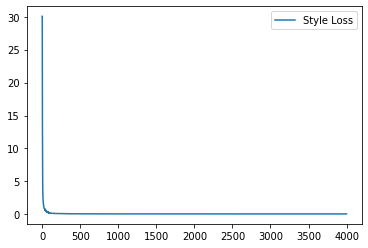

In [8]:
for itr in range(iterations):

    features = []
    def closure():
        optimizer.zero_grad()
        VGG(image)
        t_features = features[-6:]
        content = t_features[4]
        style_features = t_features[:4]+t_features[5:]
        t_features = []
        gram_styles = [gram_matrix(i) for i in style_features]
        c_loss = alpha * mse_loss(content, c_target)
        s_loss = 0

        for i in range(5):
            n_c = gram_styles[i].shape[0]
            s_loss += beta * mse_loss(gram_styles[i],gram_targets[i])/(n_c**2)

        total_loss = c_loss+s_loss

        l_c.append(c_loss)
        l_s.append(s_loss)
        
        total_loss.backward()
        return total_loss

    optimizer.step(closure)
    
    print('Step {}: S_loss: {:.8f} C_loss: {:.8f}'.format(itr, l_s[-1], l_c[-1]))
    

    if itr%1 == 0:
        temp = unload(image[0].cpu().detach())
        temp = to_image(temp)
        temp = np.array(temp)
        images.append(temp)
        imageio.mimsave('progress.gif', images)
        
    
    plt.clf()
    plt.plot(l_c, label='Content Loss')
    plt.legend()
    plt.savefig('loss1.png')
    
    plt.clf()
    plt.plot(l_s, label='Style Loss')
    plt.legend()
    plt.savefig('loss2.png')

In [0]:
plt.imsave('last.jpg',images[-1])

In [0]:
plt.imshow(images[-1])